# Particle-Field interaction example

This notebook illustrates a simple way to make particles interact with a ``` Field```  object and modify it.

The concept is similar to that of [Field sampling](https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/particle_interaction_prototype/parcels/examples/tutorial_sampling.ipynb): here instead, on top of reading the field value at their location, particles are able to alter it as defined in the ```Kernel```. To do this, it is important to keep in mind that:
- Particles have to be defined as ```ScipyParticles```
- ```Field``` values can be stored at the end of the run only, and not at each ```dt``` (at the moment — functionality in development)

In this example, particles will carry a tracer and release it into a clean ```Field``` during their advection by surface currents. To show how can particles interact with a ```Field``` and alter it, the release of such tracer is modelled here with a discretized version of the mass transfer equation, defined as follows:

\begin{equation}
\Delta c_{particle}(t) = aC_{field}(t-1) - bc_{particle}(t-1)
\tag{1}
\label{1}
\end{equation}

In Eq.1, $c_{particle}$ is the tracer concentration associated with the particle, $C_{field}$ is the tracer concentration in seawater at particle location, and $a$ and $b$ are weights that modulate the sorption of tracer from seawater and its desorption, respectively. 

Additionally to a relevant ```Kernel```, we will define a suitable particle class to store $c_{particle}$, as it is needed to solve Eq.1. 


### Particle altering a Field during advection

In [1]:
from parcels import Variable, Field, FieldSet, ParticleSet, ScipyParticle, AdvectionRK4, plotTrajectoriesFile

import numpy as np
from datetime import timedelta as delta
import netCDF4

INFO: Compiled ParcelsRandom ==> C:\Users\CASAGR~1\AppData\Local\Temp\parcels-tmp\libparcels_random_d63111b5-d6f8-4493-8874-fdc7158ed8a0.so


In this specific example, particles will be advected by surface ocean velocities stored in netCDF files in the folder ```GlobCurrent_example_data```. We will store these in a ```FieldSet``` object, and then add a ```Field``` to it to represent the tracer field. This latter field will be initialized with zeroes, as we assume that this tracer is absent on the ocean surface and released by particles only.


In [2]:
# Velocity fields
fname = r'GlobCurrent_example_data/*.nc'
filenames = {'U': fname, 'V': fname}
variables = {'U': 'eastward_eulerian_current_velocity', 'V': 'northward_eulerian_current_velocity'}
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time'},
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time'},
             }              
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

# In order to assign the same grid to the tracer field, it is convenient to load a single velocity file
fname1 = r'GlobCurrent_example_data/20030101000000-GLOBCURRENT-L4-CUReul_hs-ALT_SUM-v02.0-fv01.0.nc'
filenames1 = {'U': fname1, 'V': fname1}

field_for_size = FieldSet.from_netcdf(filenames1, variables, dimensions) # this field has the same variables and dimensions as the other velocity fields

# Adding the tracer field to the FieldSet
dimsC = [len(field_for_size.U.lat),len(field_for_size.U.lon)] # it has to have the same dimentions as the velocity fields
dataC = np.zeros([dimsC[0],dimsC[1]])

fieldC = Field('C', dataC, grid=field_for_size.U.grid) # the new Field will be called C, for tracer Concentration

fieldset.add_field(fieldC) # C field added to the velocity FieldSet

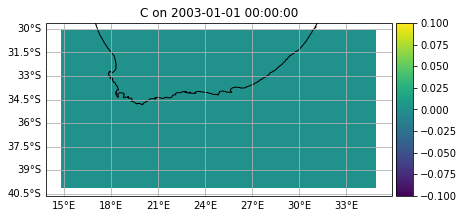

In [3]:
fieldset.C.show() # our new C field has been added to the FieldSet

Some global parameters have to be defined, such as $a$ and $b$ of Eq.1, and a weight that works as a conversion factor from $\Delta c_{particle}$ to $C_{field}$. 
We will add these parameters to the ```FieldSet```.

In [4]:
fieldset.add_constant('a', 10) 
fieldset.add_constant('b', .2) 
fieldset.add_constant('weight', .01) 

We will now define a new particle class. A ```VectorParticle``` is a ```ScipyParticle``` having a ```Variable``` to store the current tracer concentration ```c``` associated with it. As in this case we want our particles to release a tracer into a clean field, we will initialize ```c``` with an arbitrary value of `100`.

We also need to define the ```Kernel``` that performs the particle-field interaction. In this Kernel, we will implement Eq.1, so that $\Delta c_{particle}$ can be used to update $c_{particle}$ and $C_{field}$ at the particle location, and thus get their values at the current time $t$.


In [5]:
class VectorParticle(ScipyParticle):
    c = Variable('c', dtype=np.float32, initial=100.) # particle concentration c is initialized with a non-zero value
    
    
def Exchange(particle, fieldset, time):
    deltaC = (fieldset.a*fieldset.C[particle]-fieldset.b*particle.c) # the exchange is obtained as a discretized mass transfer equation
    particle.c += deltaC
    fieldset.C.data[particle.ti,particle.yi,particle.xi] += -deltaC*fieldset.weight # weight, defined as a constant for the FieldSet, acts here as a conversion factor between c_particle and C_field

    
pset = ParticleSet(fieldset=fieldset, pclass=VectorParticle, lon=[24.5], lat=[-34.8]) # for simplicity, we'll track a single particle here

exchangeKernel = pset.Kernel(Exchange)

Two things are worth noticing in the code above:
- The use of ```fieldset.C[particle]``` to obtain $C_{field}$ when calculating $\Delta c_{particle}$
- The update of $C_{field}$ through ```fieldset.C.data[particle.ti,particle.yi,particle.xi]``` 

Although they are accessing the same thing (the value of ```fieldset.C``` at particle location, i.e. $C_{field}(t-1)$), in the first point this is made through a field evaluation: in addition to returning the value of ```fieldset.C```, it updates the location indices (```ti```, ```yi```, and ```xi```) of ```pset```. The new indices are then used in the second point to access and modify the value of ```fieldset.C``` at the particle location, an operation that is only possible for ```ScipyParticles``` (and not for ```JITParticles```). 


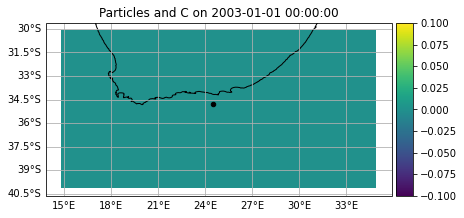

In [6]:
pset.show(field=fieldset.C) # Initial particle location and the tracer field C

Now we are going to execute the advection of the particle and the simultaneous release of the tracer it carries. We will thus add the ```Exchange``` Kernel defined above to the built-in Kernel ```AdvectionRK4```:

In [7]:
output_file = pset.ParticleFile(name='exchange.nc', outputdt=delta(days=1))

pset.execute(AdvectionRK4 + exchangeKernel,     
             dt=delta(days=1),
             runtime=delta(days=25), # we are going to track the particle and save its trajectory and tracer concentration for 25 days
             output_file = output_file)

output_file.close()

We can see that $c_{particle}$ has been saved along with particle trajectory, as expected.

[[100.          80.          64.          51.2         41.670578
   34.029205    27.729557    22.651283    18.389206    15.009227
   12.286391    10.18622      8.636798     7.034813     5.637848
    4.510278     3.6784637    2.9847028    2.3918066    1.9134452
    1.5341984    1.2273587    0.981887     0.78552765   0.63926834
    0.5360086 ]]


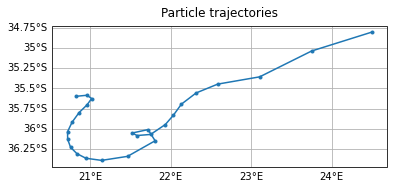

In [8]:
pset_traj = netCDF4.Dataset(r'exchange.nc')

print(pset_traj['c'][:])

plotTrajectoriesFile('exchange.nc');

But what about ```fieldset.C```? We can see that it has been accordingly modified during particle motion:

In [ ]:
c_results = fieldset.C.data[0,:,:].copy() # Copying the final field data in a new array
c_results[[field_for_size.U.data==0][0][0]]= np.nan # using a mask for fieldset.C.data on land
c_results[c_results==0] = np.nan # masking the field where its value is zero -- areas that have not been modified by the particle, for clearer plotting
    


try: # Works if Cartopy is installed
    import cartopy
    import cartopy.crs as ccrs
    import matplotlib.pyplot as plt
    extent = [10, 33, -37, -29]
    X = fieldset.U.lon
    Y = fieldset.U.lat

    plt.subplots(1,1,figsize=(12, 6))
    ax = plt.axes(projection=ccrs.Mercator())
    ax.set_extent(extent)

    ax.add_feature(cartopy.feature.OCEAN, facecolor='lightgrey')
    ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor='floralwhite')
    gl=ax.gridlines(xlocs = np.linspace(10,34,13) , ylocs=np.linspace(-29,-37,9),draw_labels=True)
    gl.right_labels = False
    gl.bottom_labels = False

    xx, yy = np.meshgrid(X,Y)

    plt.pcolormesh(xx,yy,(c_results),transform=ccrs.PlateCarree(),vmin=0,)
    cbar=plt.colorbar(ax=ax)
    cbar.ax.text(.8,.070,'$C_{field}$ concentration', rotation=270, fontsize=12)
    
except:
    print('Please install the Cartopy package.')

When looking at tracer concentrations, we see that $c_{particle}$ decreases along it trajectory (right to left), as it is releasing the tracer it carries. Accordingly, values of $C_{field}$ provided by particle interaction progressively reduce along the particle's route.

Notice that the first particle-field interaction occurs at time $t = 1$, and namely after the execution of the first step of ```AdvectionRK4```, as shown by the unaltered field value at the particle's starting location.

In [ ]:
x_centers, y_centers = np.meshgrid(fieldset.U.lon, fieldset.U.lat)

fig,ax = plt.subplots(1,1,figsize=(10,6),constrained_layout=True)
ax.set_facecolor('lightgrey') # For visual coherence with the plot above

fieldplot=ax.pcolormesh(x_centers[-28:-17,22:41],y_centers[-28:-17,22:41],c_results[-28:-18,22:40], vmin=0, vmax=0.2,cmap='viridis') 
# Zoom on the area of interest
field_cbar = plt.colorbar(fieldplot,ax=ax)
field_cbar.ax.text(.6,.070,'$C_{field}$ concentration', rotation=270, fontsize=12)

particle = plt.scatter(pset_traj['lon'][:].data[0,:],pset_traj['lat'][:].data[0,:], c=pset_traj['c'][:].data[0,:],vmin=0, s=100, edgecolor='black')  
particle_cbar = plt.colorbar(particle,ax=ax, location = 'top')
particle_cbar.ax.text(40,300,'$c_{particle}$ concentration', fontsize=12)

